In [1]:
%pwd

'c:\\Users\\Ryzen9\\Desktop\\캡2\\cap\\cap_proj\\data'

In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split


In [2]:
train_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    # 2) 회전 및 기하 변형
    transforms.RandomRotation(degrees=15),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1), scale=(0.9,1.1), shear=10),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    # 3) 색상/명암/채도/색조 변화
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.5),
    # 4) 블러, 노이즈
    transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    # 5) 수평/수직 뒤집기
    transforms.RandomHorizontalFlip(p=0.5),

    # 6) 텐서 변환 & 정규화
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
    # 7) Random Erasing (텐서 적용 후)
    transforms.RandomErasing(p=0.3, scale=(0.02,0.15), ratio=(0.3,3.3)),
])

In [3]:
val_transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])



In [4]:
data_dir = "./emotion_data"
full_ds = datasets.ImageFolder(root=data_dir, transform=train_transform)

In [5]:
# 3) Train/Val 분할
val_ratio = 0.2
val_size = int(len(full_ds) * val_ratio)
train_size = len(full_ds) - val_size
train_ds, val_ds = random_split(full_ds, [train_size, val_size])

In [6]:
# val_ds에는 val_transform 적용을 위해 transform 교체
val_ds.dataset = datasets.ImageFolder(root=data_dir, transform=val_transform)

In [7]:
# 4) DataLoader 생성
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size,
                          shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size,
                          shuffle=False, num_workers=4, pin_memory=True)

In [8]:
from collections import Counter
# 5) 클래스 확인
print("클래스:", full_ds.classes)



dataset = datasets.ImageFolder(root=data_dir)
# dataset.samples 는 [(파일경로, 클래스인덱스), …] 리스트

# 2) 클래스 인덱스만 뽑아서 개수 세기
counter = Counter([label for _, label in dataset.samples])

# 3) 클래스명과 함께 출력
for idx, cls_name in enumerate(dataset.classes):
    print(f"{cls_name:4s} : {counter[idx]} 장") 

클래스: ['angry', 'default', 'happy', 'sad']
angry : 174 장
default : 209 장
happy : 168 장
sad  : 178 장


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm  # 진행바

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet101(pretrained=True)


print("CUDA available:", torch.cuda.is_available())

c:\Users\Ryzen9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ryzen9\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CUDA available: True


In [11]:

for param in model.parameters():
    param.requires_grad = True

In [12]:
# 마지막 FC 레이어 교체
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(full_ds.classes))
model = model.to(device)


In [13]:
# 2) 손실함수와 옵티마이저
optimizer = optim.SGD(model.parameters(), lr=0.0009, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# Optional: LR 스케줄러
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
# 3) 학습·검증 루프
num_epochs = 20
train_losses = []
val_losses = []

train_acc_list = []
val_acc_list = []


best_acc = 0.0

for epoch in range(1, num_epochs+1):
    # — Training
    model.train()
    train_loss = 0
    train_correct = 0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*images.size(0)
        train_correct += (outputs.argmax(1)==labels).sum().item()
    train_loss /= len(train_loader.dataset)
    train_acc  = train_correct/len(train_loader.dataset)
    # — Va
    model.eval()
    val_loss = 0
    val_correct = 0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()*images.size(0)
            val_correct += (outputs.argmax(1)==labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_acc  = val_correct/len(val_loader.dataset)

    train_acc_list.append(train_acc)
    val_acc_list.append(val_acc)


    scheduler.step()
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch:2d} | "
          f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}\n")
    

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), 'best_model2.pth')
        print(f"Epoch {epoch}: New best acc {best_acc:.4f} → saved.")

    #print(f"Epoch {epoch}: val_acc = {val_acc:.4f} (best: {best_acc:.4f})")


Epoch 1 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



Epoch  1 | Train Loss: 1.3951, Acc: 0.2509 | Val Loss: 1.3355, Acc: 0.3525

Epoch 1: New best acc 0.3525 → saved.


Epoch 2 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch  2 | Train Loss: 1.3484, Acc: 0.3387 | Val Loss: 1.3902, Acc: 0.2950



Epoch 3 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch  3 | Train Loss: 1.3147, Acc: 0.3799 | Val Loss: 1.3637, Acc: 0.3813

Epoch 3: New best acc 0.3813 → saved.


Epoch 4 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.05s/it]



Epoch  4 | Train Loss: 1.2347, Acc: 0.4570 | Val Loss: 1.2430, Acc: 0.4317

Epoch 4: New best acc 0.4317 → saved.


Epoch 5 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch  5 | Train Loss: 1.1021, Acc: 0.5556 | Val Loss: 0.9700, Acc: 0.6259

Epoch 5: New best acc 0.6259 → saved.


Epoch 6 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch  6 | Train Loss: 0.9666, Acc: 0.6505 | Val Loss: 0.9394, Acc: 0.6475

Epoch 6: New best acc 0.6475 → saved.


Epoch 7 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]



Epoch  7 | Train Loss: 0.9502, Acc: 0.6846 | Val Loss: 0.9331, Acc: 0.6835

Epoch 7: New best acc 0.6835 → saved.


Epoch 8 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch  8 | Train Loss: 0.9216, Acc: 0.6918 | Val Loss: 0.9092, Acc: 0.6619



Epoch 9 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]



Epoch  9 | Train Loss: 0.8889, Acc: 0.7151 | Val Loss: 0.9023, Acc: 0.6763



Epoch 10 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.09s/it]



Epoch 10 | Train Loss: 0.8781, Acc: 0.7025 | Val Loss: 0.8590, Acc: 0.6763



Epoch 11 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.08s/it]



Epoch 11 | Train Loss: 0.8757, Acc: 0.6900 | Val Loss: 0.8672, Acc: 0.6906

Epoch 11: New best acc 0.6906 → saved.


Epoch 12 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]



Epoch 12 | Train Loss: 0.8620, Acc: 0.7258 | Val Loss: 0.8642, Acc: 0.6906



Epoch 13 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]



Epoch 13 | Train Loss: 0.8656, Acc: 0.7025 | Val Loss: 0.8655, Acc: 0.6691



Epoch 14 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]



Epoch 14 | Train Loss: 0.8689, Acc: 0.6935 | Val Loss: 0.8707, Acc: 0.6978

Epoch 14: New best acc 0.6978 → saved.


Epoch 15 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch 15 | Train Loss: 0.8431, Acc: 0.7168 | Val Loss: 0.8657, Acc: 0.6835



Epoch 16 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch 16 | Train Loss: 0.8532, Acc: 0.7168 | Val Loss: 0.8671, Acc: 0.6906



Epoch 17 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.07s/it]



Epoch 17 | Train Loss: 0.8302, Acc: 0.7348 | Val Loss: 0.8725, Acc: 0.6763



Epoch 18 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



Epoch 18 | Train Loss: 0.8457, Acc: 0.7258 | Val Loss: 0.8678, Acc: 0.6906



Epoch 19 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.06s/it]



Epoch 19 | Train Loss: 0.8648, Acc: 0.7061 | Val Loss: 0.8678, Acc: 0.6978



Epoch 20 [Val]: 100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Epoch 20 | Train Loss: 0.8390, Acc: 0.7258 | Val Loss: 0.8671, Acc: 0.6835



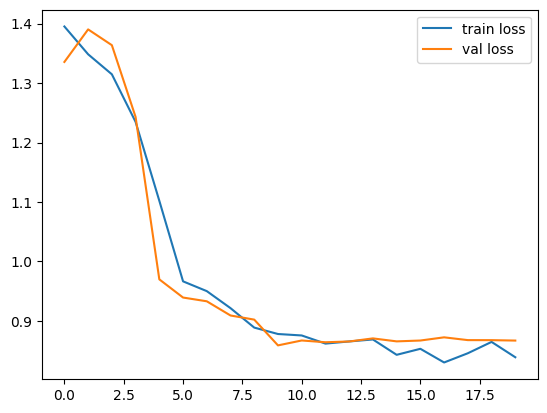

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='train loss')
plt.plot(val_losses,   label='val loss')
plt.legend(); plt.show()